In [1]:
%matplotlib inline

In [2]:
import matplotlib
matplotlib.rc('pdf', fonttype=42)

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns

# Timeline

In [4]:
_ = (
    pd.read_csv(
        'rehydrated_tweets_count_by_day.csv',
        parse_dates=['day'],
        index_col=['day', 'lang']
   )
    ['count']
    .unstack('lang', fill_value=0)
)

_['total'] = _.sum(axis=1)
_ = _[['lv', 'ru', 'en', 'total']]

timeline = _

In [5]:
timeline.head()

lang,lv,ru,en,total
day,,,,
2017-04-15,1314,367,137,1969
2017-04-16,1465,340,194,2211
2017-04-17,1366,290,177,1997
2017-04-18,2786,383,317,3670
2017-04-19,3171,453,313,4163


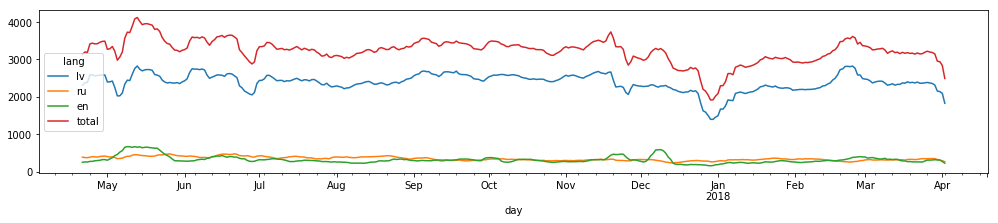

In [6]:
_ = timeline.rolling(window=7).mean().plot(figsize=(17, 3))

_.figure.savefig('rehydrated_tweets_count_by_day.pdf')

# Language usage 

In [7]:
_ = pd.read_csv('rehydrated_tweets_lang_usage.csv', index_col='rnum')

_['Language Uniformity Score'] = (_[['lv', 'ru', 'en']].max(axis=1) / _[['lv', 'ru', 'en']].sum(axis=1)).round(2)

lang_usage = _

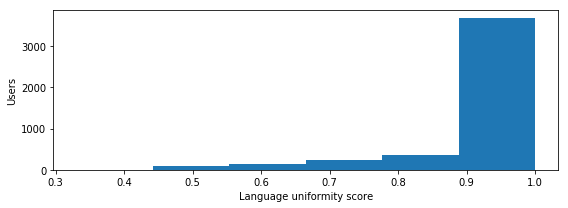

In [8]:
_ = lang_usage['Language Uniformity Score'].plot.hist(bins=6, figsize=(8, 3))

_.set(xlabel="Language uniformity score", ylabel="Users")
_.figure.tight_layout()

_.figure.savefig('rehydrated_tweets_lang_usage.pdf')

In [9]:
lang_usage.sort_values('Language Uniformity Score').head()

,lv,ru,en,total,Language Uniformity Score
rnum,,,,,
3486,7,7,7,30,0.33
1716,13,16,14,74,0.37
1442,14,18,14,92,0.39
847,48,55,34,174,0.40
3968,7,3,7,24,0.41


# Language preference

## Monolingual

In [10]:
(
    lang_usage[
        (lang_usage[['lv', 'ru', 'en']] == 0).sum(axis='columns') == 2
    ]
    [['lv', 'ru', 'en']] > 0
).sum(axis='rows')

lv    1421
ru     132
en     274
dtype: int64

## Multilingual

In [11]:
(
    lang_usage[
        (lang_usage[['lv', 'ru', 'en']] > 0).sum(axis='columns') > 1
    ]
    [['lv', 'ru', 'en']]
    .replace(0, np.nan)
    .rank(axis='columns', method='min', ascending=False)
    .apply(lambda c: c.value_counts(), axis='rows')
)

,lv,ru,en
1.0,1988,307,428
2.0,486,203,2060
3.0,76,241,108


# Topics

In [12]:
relevance_judgments_count_by_day = (
    pd.read_csv(
        'relevance_judgments_count_by_day.csv',
        index_col=['day', 'topic_id'],
        parse_dates=['day'],
    )['count']
    .unstack('topic_id', fill_value=0)
)

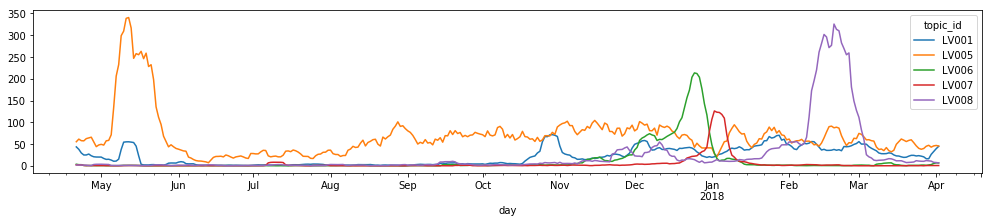

In [13]:
(
    relevance_judgments_count_by_day[['LV001', 'LV005', 'LV006', 'LV007', 'LV008']]
    .rolling(window=7).mean()
    .plot(figsize=(17, 3))
);

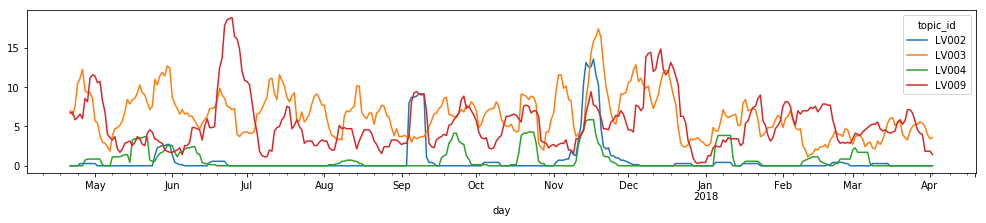

In [14]:
(
    relevance_judgments_count_by_day[['LV002', 'LV003', 'LV004', 'LV009']]
    .rolling(window=7).mean()
    .plot(figsize=(17, 3))
);

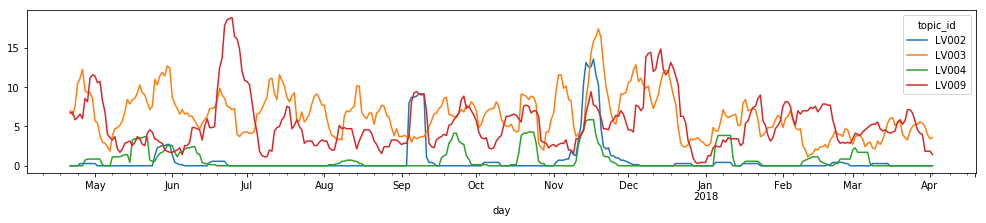

In [15]:
(
    relevance_judgments_count_by_day[['LV002', 'LV003', 'LV004', 'LV009']]
    .rolling(window=7).mean()
    .plot(figsize=(17, 3))
);

In [16]:
_ = (
    pd.read_csv(
        'relevance_judgments_lang_pref_by_day.csv',
        index_col=['day', 'topic_id'],
        parse_dates=['day'],
    )
)

_.columns = pd.MultiIndex.from_tuples(
    [
        ('Counts', 'Total'),
        ('Counts', 'lv, ru, en'),

        ('Tweets', 'lv'),
        ('Tweets', 'ru'),
        ('Tweets', 'en'),

        ('Users', 'lv'),
        ('Users', 'ru'),
        ('Users', 'en'),
    ],
    names=['Type', 'Language']
)
relevance_judgments_lang_pref_by_day = _

In [17]:
relevance_judgments_lang_pref_by_day.head()

Type                Counts            Tweets             Users            
Language             Total lv, ru, en     lv    ru    en    lv    ru    en
day        topic_id                                                       
2017-04-15 LV001        61         60   0.88  0.07  0.05  0.80  0.09  0.12
2017-04-16 LV001        58         58   0.97  0.02  0.02  0.93  0.03  0.04
2017-04-17 LV001        51         47   0.81  0.19  0.00  0.77  0.19  0.04
2017-04-18 LV001        21         21   0.86  0.14  0.00  0.85  0.14  0.01
2017-04-19 LV001        19         19   0.68  0.11  0.21  0.83  0.11  0.07

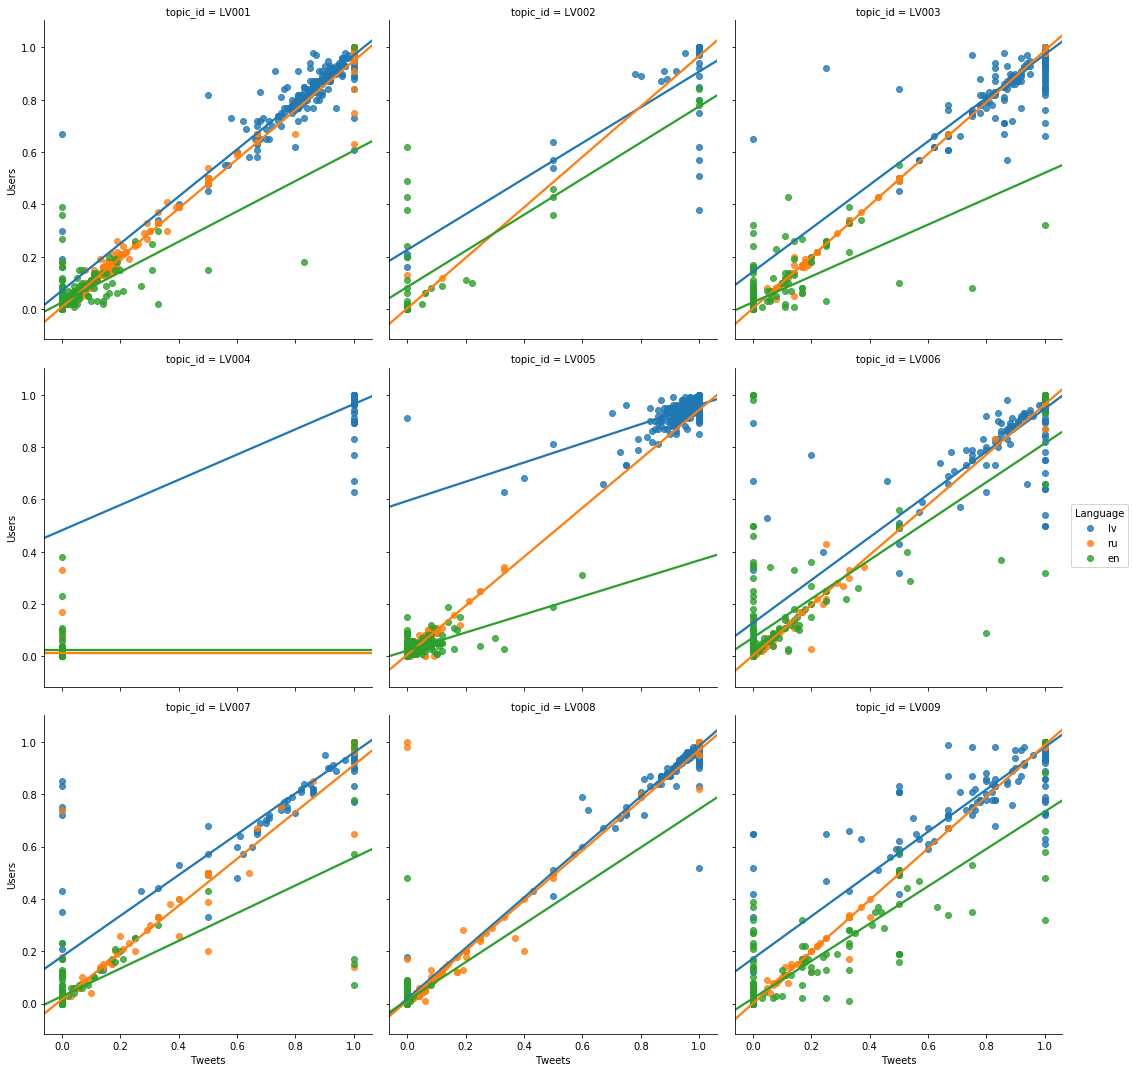

In [18]:
_ = relevance_judgments_lang_pref_by_day[['Tweets', 'Users']].stack().reset_index(['topic_id', 'Language'])

sns.lmplot(
    x='Tweets', y='Users',
    hue='Language', hue_order=['lv', 'ru', 'en'],
    col='topic_id', col_wrap=3,
    data=_,
    ci=None,
);

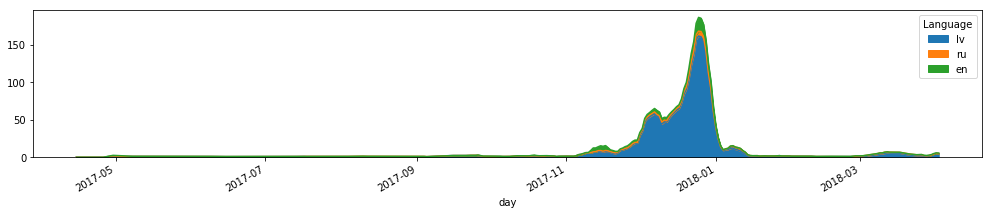

In [19]:
_ = relevance_judgments_lang_pref_by_day.loc[(slice(None), 'LV006'), :].reset_index('topic_id')

(
    _['Tweets']
    .multiply(
        _['Counts', 'lv, ru, en'],
        axis='rows',
    )
    .rolling(window=7).mean()
    .plot.area(figsize=(17, 3))
);

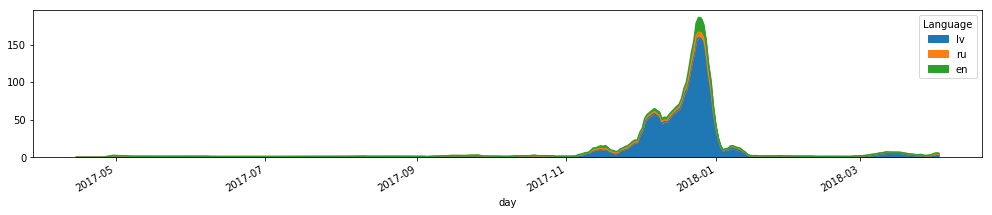

In [20]:
_ = relevance_judgments_lang_pref_by_day.loc[(slice(None), 'LV006'), :].reset_index('topic_id')

(
    _['Users']
    .multiply(
        _['Counts', 'lv, ru, en'],
        axis='rows',
    )
    .rolling(window=7).mean()
    .plot.area(figsize=(17, 3))
);

## Topics 2

In [21]:
_ = pd.read_csv(
    'relevance_judgments_lang_pref.csv',
    index_col=['topic_id', 'day'],
)[['r_lv', 'r_ru', 'r_en']]


_.columns = ['lv', 'ru', 'en']

relevance_judgments_lang_pref = _

In [22]:
relevance_judgments_lang_pref.loc[['LV005']].head()

lv   ru    en
topic_id day                                
LV005    2017-04-15 00:00:00  0.9  0.0  0.09
         2017-04-16 00:00:00  0.9  0.0  0.09
         2017-04-16 00:00:00  0.9  0.0  0.09
         2017-04-16 00:00:00  1.0  0.0  0.00
         2017-04-16 00:00:00  0.9  0.0  0.09

### Topics 3

In [23]:
relevance_judgments_count_by_day.divide?

In [24]:
_ = pd.read_csv(
    'relevance_judgments_lang_pref_by_user.csv',
    index_col=['topic_id', 'rnum'],
)

_.columns = pd.MultiIndex.from_tuples(
    [
        ('User', 'lv'),
        ('User', 'ru'),
        ('User', 'en'),
        ('User', 'total'),

        ('Topic', 'lv'),
        ('Topic', 'ru'),
        ('Topic', 'en'),
        ('Topic', 'total'),

    ],
    names=['Type', 'Language']
)

_ = _.stack('Type')
_ = _[['lv', 'ru', 'en']].divide(_['total'], axis='rows').round(2)

# _ = _.unstack('Type').stack('Language')
# _.reset_index(['Language', 'topic_id'], inplace=True, keep=True)

_ = _.unstack('Type')

_.columns = ['t_lv', 'u_lv', 't_ru', 'u_ru', 't_en', 'u_en']

relevance_judgments_lang_pref_by_user = _#[['u_lv', 'u_ru', 'u_en', 't_lv', 't_ru', 't_en']]

_.head()

t_lv  u_lv  t_ru  u_ru  t_en  u_en
topic_id rnum                                    
LV001    1      1.0  1.00   0.0   0.0   0.0   0.0
         2      1.0  1.00   0.0   0.0   0.0   0.0
         3      1.0  1.00   0.0   0.0   0.0   0.0
         4      1.0  0.99   0.0   0.0   0.0   0.0
         5      1.0  0.99   0.0   0.0   0.0   0.0

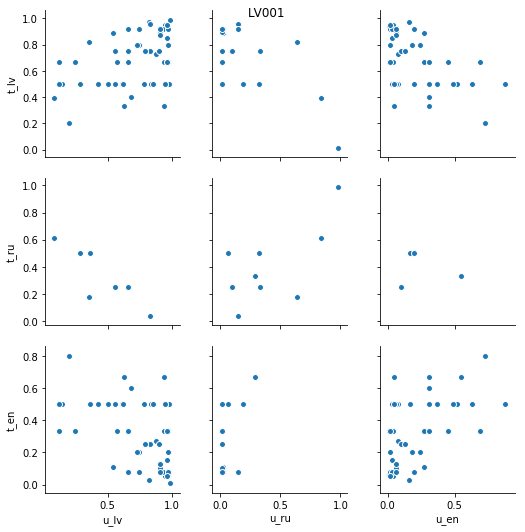

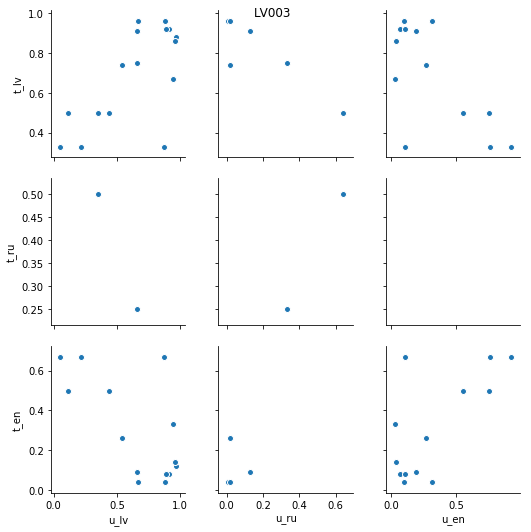

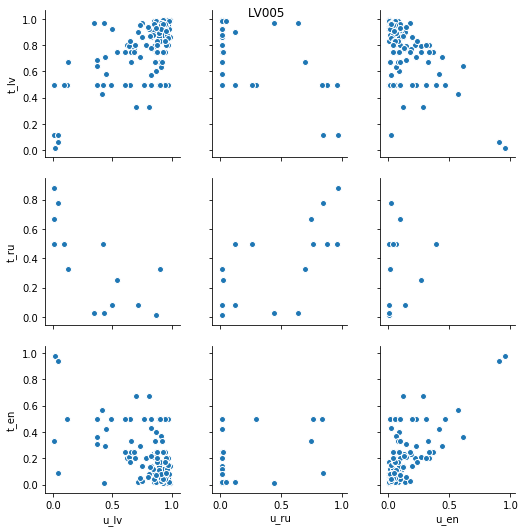

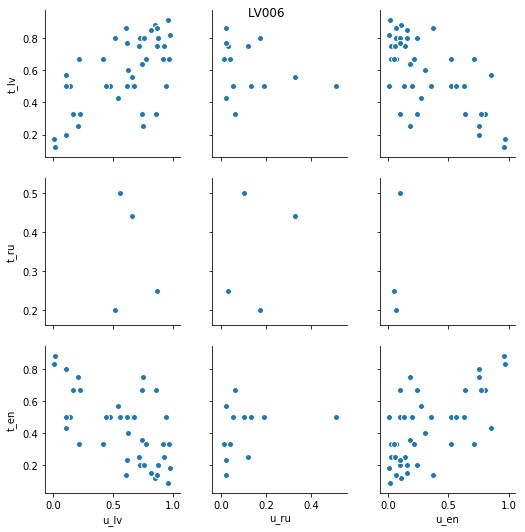

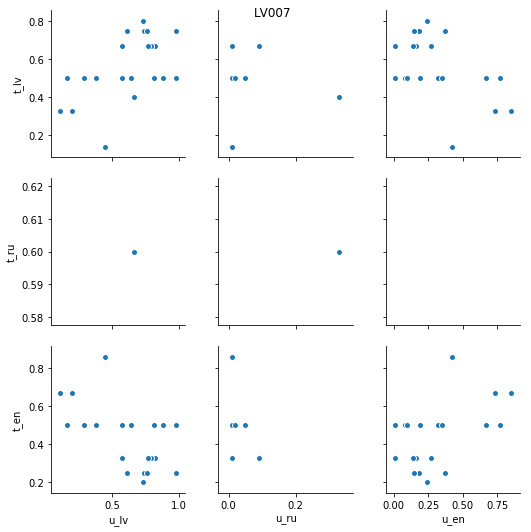

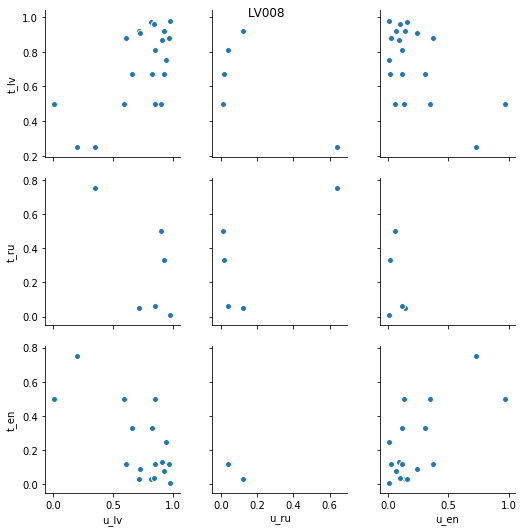

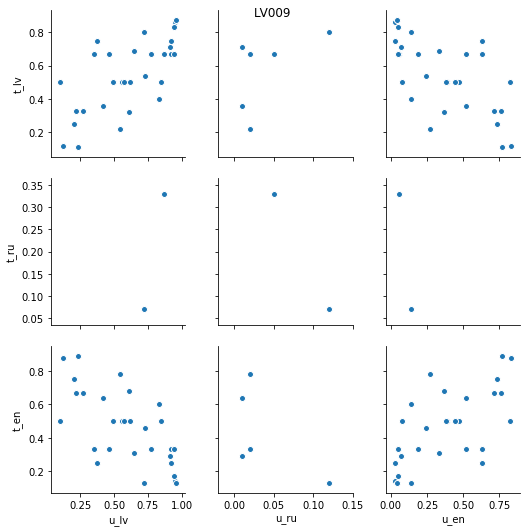

In [25]:
for topic in (
    'LV001',
    'LV003',
    'LV005',
    'LV006', 'LV007', 'LV008', 'LV009'
):

    g = sns.pairplot(
        x_vars=[
            'u_lv', 'u_ru', 'u_en'
        ],
        y_vars=[
            't_lv', 't_ru', 't_en'
        ],
        data=relevance_judgments_lang_pref_by_user.loc[topic].replace({0: np.nan, 1: np.nan}),
        kind='scatter',
    )
    
    g.fig.suptitle(topic)
    g.fig.savefig(f'lang_perf_by_user_{topic}.pdf')